<p>
<h1>OM4 Documentation Paper Figures - Temperature and Salinity Drifts</h1>
<i>J. Krasting - June 2018</i>
</p>
<p>
The analyses in this notebook compare three CORE-II forced simulations performed with OM4. These simulations differ principally in their horizontal resolution:
<ul>
<li>OM4 0.25º:  http://dora.gfdl.noaa.gov/experiments/view.php?id=980</li>
<li>OM4 0.5º:  http://dora.gfdl.noaa.gov/experiments/view.php?id=986</li>
</ul>
And a third simulation where the physical parameteization settings in the 0.5º simulation are identical to those in the 0.25º simulation:
<ul>
<li>OM4 0.5º w/o eddy param: http://dora.gfdl.noaa.gov/experiments/view.php?id=987</li>
</ul>

### Environment Set-up

In [1]:
%matplotlib inline
import cmocean
import datetime
import glob
import os
import numpy as np
import netCDF4 as nc
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
import VerticalSplitScale

from mpl_toolkits.axes_grid.inset_locator import inset_axes

print('NumPy version: %s'%(np.__version__))
print('NetCDF4 version: %s'%(nc.__version__))
print('Matplotlib version: %s'%(mpl.__version__))

NumPy version: 1.14.3
NetCDF4 version: 1.3.1
Matplotlib version: 2.2.2


/net/aja/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
#plt.rcParams.update({'font.size': 12})

### Define a class to hold the experiment data

In [3]:
class experiment:
    def __init__(self,pathpp,label,linecolor):
        def _load_variable(filelist,varname):
            f = nc.MFDataset(filelist)
            x = f.variables[varname][:]
            times = f.variables['time']
            t = list(nc.num2date(times[:],units=times.units,calendar=times.calendar))
            f.close()
            return x, t
        # Set color for line plots
        self.linecolor = linecolor
        # Set experiment name
        self.label = label
        # Standardize path names with no trailing slash
        pathpp = os.path.abspath(pathpp)        
        # Construct of a list of files associated with the experiment
        staticfile = pathpp+'/ocean_annual_z/ocean_annual_z.static.nc'
        thetaoga_files = sorted(glob.glob(pathpp+'/ocean_scalar_annual/ts/annual/20yr/*.thetaoga.nc'))
        tosga_files = sorted(glob.glob(pathpp+'/ocean_scalar_annual/ts/annual/20yr/*.tosga.nc'))
        ave_hfds_files = sorted(glob.glob(pathpp+'/ocean_scalar_annual/ts/annual/20yr/*.ave_hfds.nc'))
        soga_files = sorted(glob.glob(pathpp+'/ocean_scalar_annual/ts/annual/20yr/*.soga.nc'))
        thetao_xyave_files = sorted(glob.glob(pathpp+'/ocean_annual_z/ts/annual/20yr/*.thetao_xyave.nc'))
        so_xyave_files = sorted(glob.glob(pathpp+'/ocean_annual_z/ts/annual/20yr/*.so_xyave.nc'))
        # Dmget the files from archive
        print('Dmgetting files ... ',end='')
        output = subprocess.run(['dmget','staticfile']+thetaoga_files+soga_files+thetao_xyave_files+so_xyave_files)
        print('Done!')
        # Load the coordinates needed for the analysis
        f = nc.Dataset(staticfile)
        self.deptho = f.variables['deptho'][:]
        self.xh = f.variables['xh'][:]
        self.yh = f.variables['yh'][:]
        self.geolat = f.variables['geolat'][:]
        self.geolon = f.variables['geolon'][:]
        f.close()
        # Load the data from the NetCDF files
        self.thetaoga, self.time = _load_variable(thetaoga_files,'thetaoga')
        self.tosga,_ = _load_variable(tosga_files,'tosga')
        self.ave_hfds,_ = _load_variable(ave_hfds_files,'ave_hfds')
        self.soga,_ = _load_variable(soga_files,'soga')
        self.thetao_xyave,_ = _load_variable(thetao_xyave_files,'thetao_xyave')
        self.so_xyave,_ = _load_variable(so_xyave_files,'so_xyave')
        # Read vertical levels and interfaces
        self.z_l,_ = _load_variable(thetao_xyave_files,'z_l')
        self.z_i,_ = _load_variable(thetao_xyave_files,'z_i')
        self.z_l = self.z_l*-1.
        self.z_i = self.z_i*-1.

### Define a smoother function

In [4]:
def smooth(x,window_len=10):
    w=np.ones(window_len,'d')
    y=np.convolve(w/w.sum(),x,mode='same')
    y[0:np.int(np.ceil(window_len/2.))] = np.nan
    y[-1*np.int(np.ceil(window_len/2.))::] = np.nan
    return y

### Functions for handling figure output

These are some helper functions to set up the matplotlib figures.  For AMS journals, single column figures are 19 picas, double column figures are 33 picas, and full-page figures are 39 picas. Not sure if this is also true for AGU journals.

In [5]:
fig_dir = '.'
dpi = 150

def set_figure(picas,aspect=(16,9)):
    w = picas*(1./6.)*2.
    h = w * (float(aspect[1])/float(aspect[0]))
    return plt.figure(figsize=(w,h))

### Load data for each of the experiments

Color selections taken from http://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3 but these values could be changed to anything.

In [18]:
OM4_025 = experiment('/archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/'+
                     'gfdl.ncrc4-intel16-prod/pp','OM4p25','#018571')

OM4_05 = experiment('/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/'+
                    'OM4p5_IAF_BLING_CFC_abio_csf_mle200/gfdl.ncrc4-intel16-prod/pp','OM4p5','#80cdc1')

OM4_05_SM = experiment('/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/'+
                    'OM4p5_IAF_BLING_CFC_abio_csf_mle500/gfdl.ncrc4-intel16-prod/pp','OM4p5e','#dfc27d')

OM4_05_NEP = experiment('/archive/oar.gfdl.bgrp-account/CMIP6/OMIP/warsaw_201803_mom6_2018.04.11/'+
                        'OM4p5_IAF_BLING_CFC_abio_csf_p25config/gfdl.ncrc4-intel16-prod/pp','OM4p5n','#a6611a')

OM4_025_z = experiment('/archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_zstar/'+
                     'gfdl.ncrc4-intel16-prod/pp','OM4p25-z*','r')

experiments = [OM4_025_z,OM4_025,OM4_05_NEP,OM4_05_SM,OM4_05]
#experiments = [OM4_05_NEP,OM4_05_SM,OM4_05,OM4_025_z,OM4_025]

Dmgetting files ... Done!
Dmgetting files ... Done!
Dmgetting files ... Done!
Dmgetting files ... Done!
Dmgetting files ... Done!


### Time series of volume mean temperature and salinity

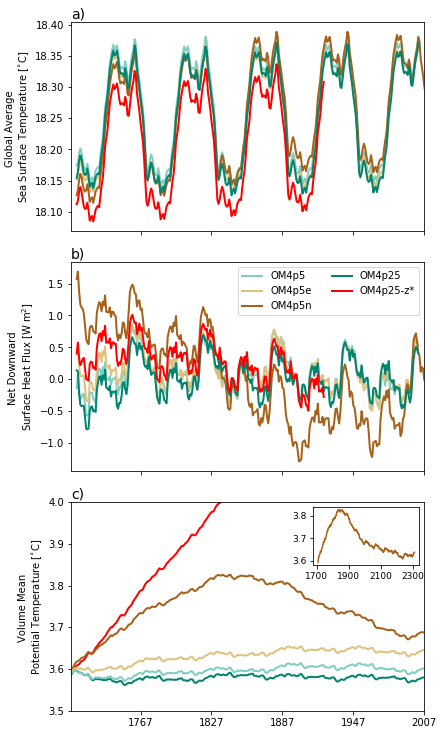

In [19]:
smg09_limits = False
xlim = (1708,2007)

# Initialize the figure
fig = set_figure(19,aspect=(7,14))

# SST panel 
ax1 = plt.subplot(3,1,1)
for n,e in enumerate(experiments[-1::-1]):
    tax = [x.year for x in e.time]
    plotvar = smooth(e.tosga,window_len=10)
    plt.plot(tax,plotvar,color=e.linecolor,linewidth=2)
    #if n == 0: sst_stacked = plotvar[None,0:300]
    #else: sst_stacked = np.concatenate((sst_stacked,plotvar[None,0:300]),axis=0)
plt.xlim(xlim)
plt.ylabel('Global Average \nSea Surface Temperature [$^{\circ}$C]')

# Heat flux panel 
ax2 = plt.subplot(3,1,2)
for n,e in enumerate(experiments[-1::-1]):
    tax = [x.year for x in e.time]
    mean_hfds = np.mean(e.ave_hfds[-60::])
    plotvar = smooth(e.ave_hfds-mean_hfds,window_len=10)
    plt.plot(tax,plotvar,color=e.linecolor,linewidth=2,label=e.label)
plt.xlim(xlim)
plt.ylabel('Net Downward \nSurface Heat Flux [W m$^{2}$]')
plt.legend(loc=1,fontsize=10,ncol=2)

# Volume mean temperature  panel
if smg09_limits is True:
    ylim = (1.,4.5)
    loc=4
else:
    ylim = (3.5,4.0)
    loc=1

ax3 = plt.subplot(3,1,3)
for n,e in enumerate(experiments):
    tax = [x.year for x in e.time]
    plt.plot(tax,e.thetaoga,color=e.linecolor,linewidth=2)
    #if n == 0: thetaoga_stacked = e.thetaoga[None,0:300]
    #else: thetaoga_stacked = np.concatenate((thetaoga_stacked,e.thetaoga[None,0:300]),axis=0)
plt.xlim(xlim)
plt.ylim(ylim)
plt.ylabel('Volume Mean \nPotential Temperature [$^{\circ}$C]')
if smg09_limits is True: plt.ylim(1.,4.5)
ax3_inset = inset_axes(ax3,width="30%",height=.8,loc=loc)
e = OM4_05_NEP
tax = [x.year for x in e.time]
plt.plot(tax,e.thetaoga, color=e.linecolor)
ax3_inset.set_xticks([1700,1900,2100,2300])
plt.tick_params(axis='both', which='major', labelsize=9)
if smg09_limits is True: plt.ylim(ylim)

for ax in [ax1,ax2,ax3]: ax.set_xticks([1767,1827,1887,1947,2007])    
for ax in [ax1,ax2]: ax.set_xticklabels([])

plt.subplots_adjust(wspace=0.3,hspace=0.15)

#-- Add letters over plots
subplots = [(ax1,'a)'),(ax2,'b)'),(ax3,'c)')]
for s in subplots: s[0].text(0.0,1.02,s[1],fontsize=14,transform=s[0].transAxes)

plt.savefig('heat-uptake-sst-flux-vmean.png')

In [14]:
print('Net Heat Flux OM4p25: '+str(np.mean(OM4_025.ave_hfds[:])))
print('Net Heat Flux OM4p5: '+str(np.mean(OM4_05.ave_hfds[:])))
print('Net Heat Flux OM4p5e: '+str(np.mean(OM4_05_SM.ave_hfds[:])))
print('Net Heat Flux OM4p5b: '+str(np.mean(OM4_05_NEP.ave_hfds[:])))
print('Net Heat Flux OM4p25z: '+str(np.mean(OM4_025_z.ave_hfds[:])))

print('Drift OM4p25: '+str(np.polyfit(tax[0:300],OM4_025.thetaoga[:],1)[0]*100.))
print('Drift OM4p5: '+str(np.polyfit(tax[0:300],OM4_05.thetaoga[:],1)[0]*100.))
print('Drift OM4p5e: '+str(np.polyfit(tax[0:300],OM4_05_SM.thetaoga[:],1)[0]*100.))
#print('Drift OM4p5n: '+str(np.polyfit(tax[0:300],OM4_05_NEP.thetaoga[:],1)[0]*100.))

print('Drift OM4p5n Cyc. 1-2: '+str(np.polyfit(tax[0:120],OM4_05_NEP.thetaoga[0:120],1)[0]*100.))
print('Drift OM4p5n Cyc. 3-5: '+str(np.polyfit(tax[120:300],OM4_05_NEP.thetaoga[120:300],1)[0]*100.))
print('Drift OM4p5n Cyc. 5-10: '+str(np.polyfit(tax[300:],OM4_05_NEP.thetaoga[300:],1)[0]*100.))

Net Heat Flux OM4p25: -0.10699219444509084
Net Heat Flux OM4p5: -0.08169166553456281
Net Heat Flux OM4p5e: -0.010207852504942959
Net Heat Flux OM4p5b: -0.06004410102965241
Net Heat Flux OM4p25z: 1.4340863925860767
Drift OM4p25: 0.0005880529219210637
Drift OM4p5: 0.00779068652959605
Drift OM4p5e: 0.016455118739449284
Drift OM4p5n Cyc. 1-2: 0.17660281847529175
Drift OM4p5n Cyc. 3-5: -0.09813276433791095
Drift OM4p5n Cyc. 5-10: -0.019944216097457303


### Depth-vs-time plots of horizontal-average temperature and salinity

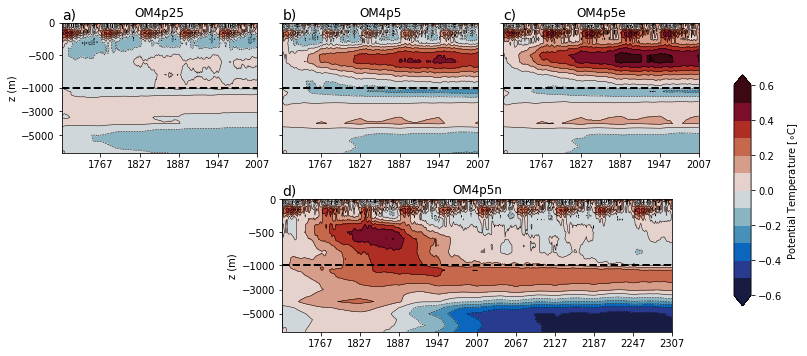

In [9]:
smg09_limits = False
if smg09_limits is True:
    levels = np.arange(-0.3,0.32,0.02)
else:
    levels = np.arange(-0.6,0.65,0.1)
    
cmap = cmocean.cm.balance
norm = mpl.colors.BoundaryNorm(levels, cmap.N) 

axes = [] ; cfs = [] ; cls = []

def _plot_panel(e,ylabel=True):
    drift = (e.thetao_xyave - e.thetao_xyave[0])
    drift = drift.T
    tax = [x.year for x in e.time]
    cf = plt.contourf(tax,e.z_l,drift,levels=levels,cmap=cmap,norm=norm,extend='both')
    cl = plt.contour(tax,e.z_l,drift,levels=levels,colors=['k'],linewidths=0.5)
    plt.plot(tax,np.array(tax)*0.-1000.,'k--',linewidth=2)
    if ylabel is True:
        plt.ylabel('z (m)')
    plt.title(e.label)
    cfs.append(cf)
    cls.append(cl)
    return cf

fig = set_figure(39,aspect=(16,7))

ax1 = plt.subplot2grid((16,16), (0,0),  rowspan=7, colspan=4)
cf1 = _plot_panel(OM4_025)

ax2 = plt.subplot2grid((16,16), (0,5),  rowspan=7, colspan=4)
cf2 = _plot_panel(OM4_05)

ax3 = plt.subplot2grid((16,16), (0,10), rowspan=7, colspan=4)
cf3 = _plot_panel(OM4_05_SM)

ax4 = plt.subplot2grid((32,32), (18, 10), rowspan=14, colspan=17)
cf4 = _plot_panel(OM4_05_NEP)

ax5 = plt.subplot2grid((60,60), (10,56), rowspan=45, colspan=1)
plt.colorbar(cf4,cax=ax5,orientation='vertical',extend='both',label='Potential Temperature [$\circ$C]')

#-- invert y-axis and apply split scale
for ax in [ax1,ax2,ax3,ax4]:
    ax.invert_yaxis()
    ax.set_yscale('splitscale', zval=[0.,-1000.,-6500.])
    ax.set_yticks([-5000,-3000,-1000,-500,0])
    ax.set_xticks([1767,1827,1887,1947,2007])

ax4.set_xticks([1767,1827,1887,1947,2007,2067,2127,2187,2247,2307])

for ax in [ax2,ax3]:
    ax.set_yticklabels([])
    ax.set_ylabel('')
    
plt.subplots_adjust(wspace=-0.3,hspace=0.8)

# Set poition of ax4 exactly
bb2,bb4 = ax2.get_position(), ax4.get_position()
ax4.set_position([bb2.x0,bb4.y0,bb4.x1-bb4.x0,bb4.y1-bb4.y0])

#-- Add letters over plots
subplots = [(ax1,'a)'),(ax2,'b)'),(ax3,'c)'),(ax4,'d)')]
for s in subplots: s[0].text(0.0,1.028,s[1],fontsize=14,transform=s[0].transAxes)

plt.savefig('heat-uptake-t-drift.png')

### Temperature drifts plotted as a profile

Text(0.5,0,'Potential Temperature Drift \n[$\\circ$C / century]')

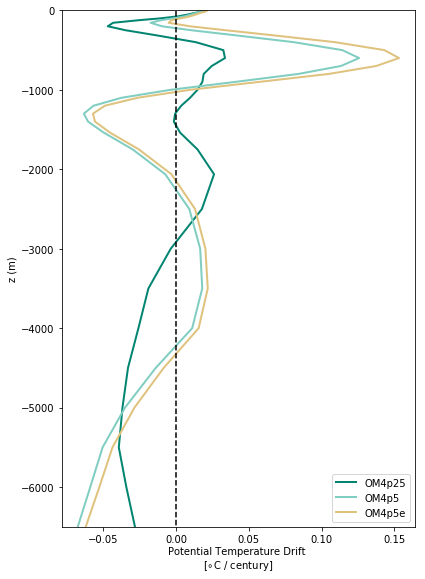

In [10]:
fig = set_figure(19,aspect=(8,12))

tax = np.array([x.year for x in OM4_025.time])

def _linear_trend(x,t=None):
    return np.polyfit(t,x,1)[0]

lines = []
for e in [OM4_025,OM4_05,OM4_05_SM]:
    trend = np.apply_along_axis(_linear_trend,0,e.thetao_xyave,t=tax)
    line = plt.plot(trend*100,e.z_l,color=e.linecolor,linewidth=2,label=e.label)
    lines.append(line)
    
plt.plot(e.z_l*0,e.z_l,'k--')
plt.ylim(-6500,0)
plt.legend(loc=4)

plt.ylabel('z (m)')
plt.xlabel('Potential Temperature Drift \n[$\circ$C / century]')

### Text for the OM4 documentation manuscript

The 3-hourly prescribed fluxes tightly constrain the surface ocean properties under the CORE-II (IAF) forcing.  The 60-year cyclic forcing is evident in the timeseries of global mean sea surface temperature (Fig. a) but the spread among the ensemble of configurations (OM4p25, OM4p5, OM4p5e, and OM4p5n) only varies between 0.01 and 0.05 $^\circ$C.  Initially, OM4p5n is the coldest ensemble member but becomes the warmest by the end of the 5th focrcing cycle. Despite some subtle differences, OM4p25, OM4p5, and OM4p5e are also well-balanced in terms of their net downward surface heat fluxes, with averages of less than 0.1 W/m2 over the 300 years of simulation.  In the OM4p5n configuration, decadal-average heat fluxes into the ocean are initially 1.5 W/m2 and remain positive over the first two forcing cycles before becoming negative over cycles 3 through 5.  Since the surface climate is strongly constrained by the boundary forcing in all of these simulations, these changes in the volume mean ocean potential temperature and downward surface heat flux reflect model drift related to internal processes.

The OM4p25 simulation is remarkably stable with a volume mean ocean potential temperature drift of 0.0006 $^\circ$C/century (Fig. C). The depth vs. time evolution of potential temperature shows slight cooling above 500m depth, a maximum of warming near 2000m depth, and cooling in the abyssal waters below 4000m. The volume mean drift is slighlty larger in OM4p5 (0.008 $^\circ$C/century) and OM4p5e (0.02 $^\circ$C/century). The depth vs. time evolution of potential temperature is very different in the two 0.5$^\circ$ configurations, with much of the warm drift concentrated between 500 and 1000m depth. Both configurations also show cooling in the sub-thermocline waters below 1000m and there is enhanced warming relative to the 0.25$^\circ$  configuration between 3000 and 4000m.  The abyssal cooling is similar in magnitude between the 0.5$^\circ$ and 0.25$^\circ$ configurations, but the maximum of cooling is centered deeper in the water column in the OM4p5 and OM4p5e. While OM4p5 and OM4p5 look very similar throughout the water column, they differ most in the upper 500m where OM4p5 tends to cool slightly whereas OM4p5e warms slightly.  This difference highlights the role of the submesoscale paramaterization difference in model drift in the 0.5$^\circ$ configurations.

Unlike the other three configurations previously discussed, OM4p5n has centennial-scale structure in the volume mean potential temperature drift.  The ocean warms at a rate of 0.2 $^\circ$C/century over the first two forcing cycles, driven primarily by wamrming in the upper 1000m.  Beginnning in the third cycle, this upper-ocean warming ceases and is replaced by cooling the abyssal waters.  Over CORE cycles 3 through 5, the volume mean ocean temperature cools at a rate of -0.1 $^\circ$C/century.  The switch from upper ocean warming the abyssal cooling is related to changes in high latitude ventialation and deep water formation that will be discussing in more detail in Section XX.  The OM4p5n experiment ran for an addition 5 cycles and the volume mean temperature continued its slight cooling trend of -0.02 $^\circ$C/century (Fig. c, inset).